# Importing Libraries

In [1]:
import numpy as  np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

2021-09-29 13:56:11.683280: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-29 13:56:11.683409: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Dataset

In [2]:
data = pd.read_csv('../input/car-damage-assessment/data.csv')
data.head()

,Unnamed: 0,image,classes
0,0,image/0.jpeg,unknown
1,1,image/1.jpeg,head_lamp
2,2,image/2.jpeg,door_scratch
3,3,image/3.jpeg,head_lamp
4,4,image/4.jpeg,unknown


In [3]:
# Drop 'Unnamed: 0'
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594 entries, 0 to 1593
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1594 non-null   object
 1   classes  1594 non-null   object
dtypes: object(2)
memory usage: 25.0+ KB


### Checking for null values

In [5]:
data.isnull().sum()

image      0
classes    0
dtype: int64

### bar graph showing "classes"

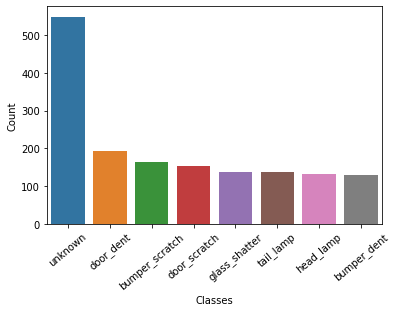

In [6]:
counts = data['classes'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=40);

In [7]:
path = '../input/car-damage-assessment/'
def edit_path_img(x):
    return path + x

In [8]:
data["image"] = data["image"].apply(edit_path_img)
data.head()

,image,classes
0,../input/car-damage-assessment/image/0.jpeg,unknown
1,../input/car-damage-assessment/image/1.jpeg,head_lamp
2,../input/car-damage-assessment/image/2.jpeg,door_scratch
3,../input/car-damage-assessment/image/3.jpeg,head_lamp
4,../input/car-damage-assessment/image/4.jpeg,unknown


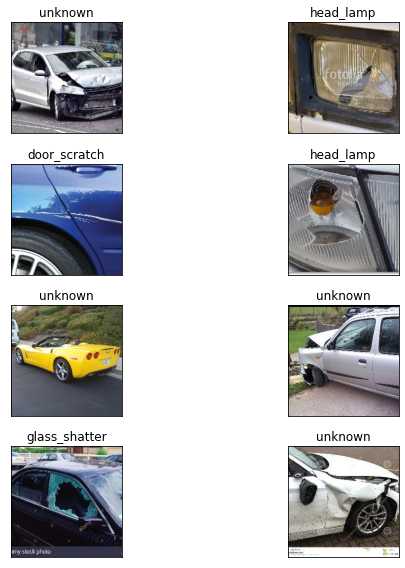

In [9]:
datafig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.image[i]))
    ax.set_title(data.classes[i])
plt.tight_layout()
plt.show()

# Train & Test Split

In [10]:
train_df, test_df = train_test_split(data, test_size=0.2)

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [12]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=0
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1275 validated image filenames belonging to 8 classes.
Found 1275 validated image filenames belonging to 8 classes.
Found 319 validated image filenames belonging to 8 classes.


In [13]:
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

2021-09-29 13:56:21.323371: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-29 13:56:21.326316: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-29 13:56:21.326351: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-29 13:56:21.326382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (38ac2691f9a8): /proc/driver/nvidia/version does not exist
2021-09-29 13:56:21.326737: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

9412608/9406464 [==============================] - 0s 0us/step


In [14]:
inputs = pretrained_model.input
x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [17]:
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=my_callbacks)

2021-09-29 13:56:23.423199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-29 13:56:23.429278: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/50
40/40 [==============================] - 72s 2s/step - loss: 1.6049 - accuracy: 0.4445 - val_loss: 0.6562 - val_accuracy: 0.8016
Epoch 2/50
40/40 [==============================] - 67s 2s/step - loss: 0.6024 - accuracy: 0.8231 - val_loss: 0.3426 - val_accuracy: 0.9106
Epoch 3/50
40/40 [==============================] - 67s 2s/step - loss: 0.3949 - accuracy: 0.8751 - val_loss: 0.2268 - val_accuracy: 0.9420
Epoch 4/50
40/40 [==============================] - 67s 2s/step - loss: 0.2217 - accuracy: 0.9464 - val_loss: 0.2268 - val_accuracy: 0.9255
Epoch 5/50
40/40 [==============================] - 67s 2s/step - loss: 0.1770 - accuracy: 0.9496 - val_loss: 0.0854 - val_accuracy: 0.9851
Epoch 6/50
40/40 [==============================] - 67s 2s/step - loss: 0.0672 - accuracy: 0.9925 - val_loss: 0.0541 - val_accuracy: 0.9969
Epoch 7/50
40/40 [==============================] - 88s 2s/step - loss: 0.0717 - accuracy: 0.9869 - val_loss: 0.0275 - val_accuracy: 0.9992
Epoch 8/50
40/40 [==

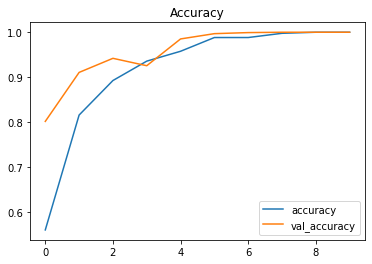

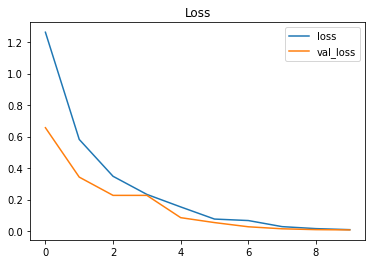

In [18]:
# Plotting Accuracy and val_accuracy
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# Plotting loss and val_loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [19]:
# Calculating Test Accuracy and Loss
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.79887
Test Accuracy: 78.06%


In [20]:
pred = model.predict(test_gen )
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [21]:
# Classification report
y_test = list(test_df.classes)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

   bumper_dent       0.55      0.63      0.59        27
bumper_scratch       0.91      1.00      0.95        39
     door_dent       0.71      0.61      0.66        41
  door_scratch       0.65      0.80      0.71        25
 glass_shatter       0.84      0.84      0.84        25
     head_lamp       0.54      0.71      0.61        21
     tail_lamp       0.86      0.68      0.76        37
       unknown       0.90      0.84      0.87       104

      accuracy                           0.78       319
     macro avg       0.74      0.76      0.75       319
  weighted avg       0.79      0.78      0.78       319



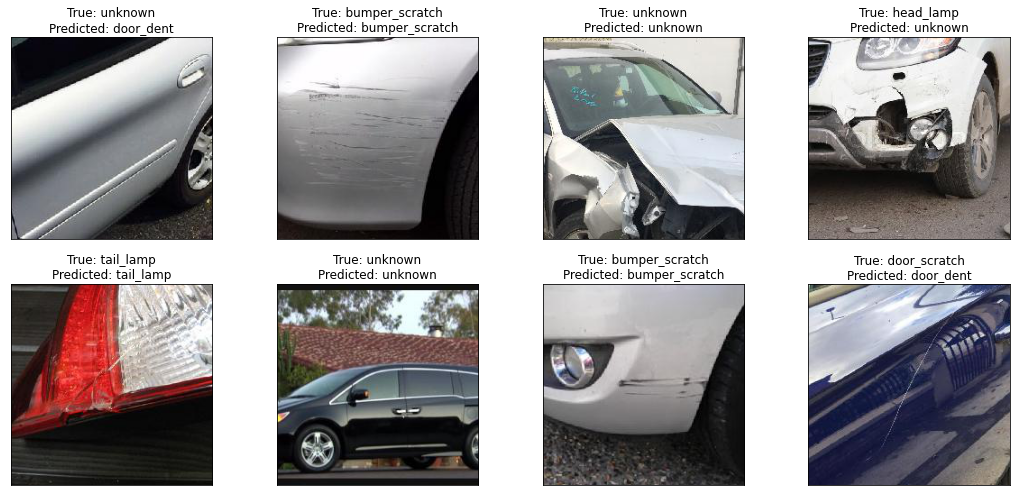

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.image.iloc[i]))
    ax.set_title(f"True: {test_df.classes.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()